紫外线数据 https://data.weather.gov.hk/weatherAPI/cis/csvfile/KP/ALL/daily_KP_UV_ALL.csv

In [3]:
import requests

url = 'https://data.weather.gov.hk/weatherAPI/opendata/opendata.php?dataType=CLMTEMP&rformat=csv&station=HKA'

response = requests.get(url)
response.raise_for_status()

data = response.text
data

'\ufeff"\ufeff平均氣溫 (攝氏度) - 香港國際機場"\n"Mean Temperature (°C) - Hong Kong International Airport"\n年/Year,月/Month,日/Day,數值/Value,"數據完整性/data Completeness"\n1997,6,1,28.3,C\n1997,6,2,29.2,C\n1997,6,3,28.9,C\n1997,6,4,28.7,C\n1997,6,5,29.4,C\n1997,6,6,29.9,C\n1997,6,7,29.7,C\n1997,6,8,30.1,C\n1997,6,9,30.2,C\n1997,6,10,28.6,C\n1997,6,11,26.6,C\n1997,6,12,28.1,C\n1997,6,13,26.0,C\n1997,6,14,26.1,C\n1997,6,15,25.4,C\n1997,6,16,24.7,C\n1997,6,17,24.7,C\n1997,6,18,25.0,C\n1997,6,19,26.7,C\n1997,6,20,28.1,C\n1997,6,21,28.1,C\n1997,6,22,27.5,C\n1997,6,23,29.1,C\n1997,6,24,28.7,C\n1997,6,25,29.0,C\n1997,6,26,27.7,C\n1997,6,27,28.1,C\n1997,6,28,28.2,C\n1997,6,29,28.4,C\n1997,6,30,28.7,C\n1997,7,1,27.7,C\n1997,7,2,28.1,C\n1997,7,3,26.4,C\n1997,7,4,28.3,C\n1997,7,5,29.1,C\n1997,7,6,27.7,C\n1997,7,7,29.6,C\n1997,7,8,28.9,C\n1997,7,9,29.2,C\n1997,7,10,28.1,C\n1997,7,11,29.0,C\n1997,7,12,29.4,C\n1997,7,13,29.7,C\n1997,7,14,29.2,C\n1997,7,15,27.9,C\n1997,7,16,27.6,C\n1997,7,17,27.1,C\n1997,7,18,27.4,C\n19

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# 最后一条数据 2024-10-31

# Load the data
UV_file = './daily_KP_UV_ALL.csv'
Climax_file = './CLMMAXT_HKA_.csv'
MSLP_file = './daily_HKA_MSLP_ALL.csv'
RH_file = './daily_HKA_RH_2024.csv'
DEW_file = './daily_HKA_DEW_2024.csv'
# 去掉前两行
UV = pd.read_csv(UV_file, skiprows=2)
Climax = pd.read_csv(Climax_file, skiprows=2)
MSLP = pd.read_csv(MSLP_file, skiprows=2)
RH = pd.read_csv(RH_file, skiprows=2)
DEW = pd.read_csv(DEW_file, skiprows=2)

def preprocess(df):
    # 去掉df['年/Year']列中不是数字的行
    df = df[df['年/Year'].apply(lambda x: str(x).replace('.', '', 1).isdigit())]

    # 将年月日设置为int类型
    df.loc[:, '年/Year'] = df['年/Year'].astype(int)
    df.loc[:, '月/Month'] = df['月/Month'].astype(int)
    df.loc[:, '日/Day'] = df['日/Day'].astype(int)

    # 取出2014年之后的数据
    df = df[df['年/Year'] >= 2024]

    # 重命名列以便 pd.to_datetime 正确识别
    df = df.rename(columns={'年/Year': 'year', '月/Month': 'month', '日/Day': 'day'})

    # 将年月日合并为一个datetime列
    df['datetime'] = pd.to_datetime(df[['year', 'month', 'day']])

    # 重命名数值/Value列为value
    df = df.rename(columns={'數值/Value': 'value'})
    # 取出datetime和value列 並重新排列順序
    df = df[['datetime', 'value']]

    return df

UV_preprocessed = preprocess(UV) # 紫外线
Climax_preprocessed = preprocess(Climax) # 温度 
MSLP_preprocessed = preprocess(MSLP) # 气压
RH_preprocessed = preprocess(RH) # 相对湿度
DEW_preprocessed = preprocess(DEW) # 露点温度

# 合并所有数据集，按日期进行对齐, 命名为value_{name}
all_data = pd.DataFrame(UV_preprocessed['datetime'])
all_data = all_data.set_index('datetime')

# 添加后缀到每个数据集
UV_preprocessed = UV_preprocessed.rename(columns={'value': 'value_UV'})
Climax_preprocessed = Climax_preprocessed.rename(columns={'value': 'value_Climax'})
MSLP_preprocessed = MSLP_preprocessed.rename(columns={'value': 'value_MSLP'})
RH_preprocessed = RH_preprocessed.rename(columns={'value': 'value_RH'})
DEW_preprocessed = DEW_preprocessed.rename(columns={'value': 'value_DEW'})

# 合并所有数据
all_data = all_data.join(UV_preprocessed.set_index('datetime'), how='outer')
all_data = all_data.join(Climax_preprocessed.set_index('datetime'), how='outer')
all_data = all_data.join(MSLP_preprocessed.set_index('datetime'), how='outer')
all_data = all_data.join(RH_preprocessed.set_index('datetime'), how='outer')
all_data = all_data.join(DEW_preprocessed.set_index('datetime'), how='outer')

# 设置其他列为float
all_data['value_UV'] = all_data['value_UV'].astype(float)
all_data['value_Climax'] = all_data['value_Climax'].astype(float)
all_data['value_MSLP'] = all_data['value_MSLP'].astype(float)
all_data['value_RH'] = all_data['value_RH'].astype(float)
all_data['value_DEW'] = all_data['value_DEW'].astype(float)

all_data


,value_UV,value_Climax,value_MSLP,value_RH,value_DEW
datetime,,,,,
2024-01-01,2.0,24.8,1019.7,65.0,14.0
2024-01-02,1.0,22.4,1019.2,68.0,13.5
2024-01-03,2.0,22.2,1020.5,59.0,10.5
2024-01-04,2.0,20.0,1021.3,58.0,8.2
2024-01-05,2.0,22.0,1020.2,68.0,13.1
...,...,...,...,...,...
2024-10-27,2.0,29.9,1009.4,68.0,20.6
2024-10-28,2.0,27.7,1010.4,62.0,17.8
2024-10-29,2.0,27.0,1011.2,63.0,17.7


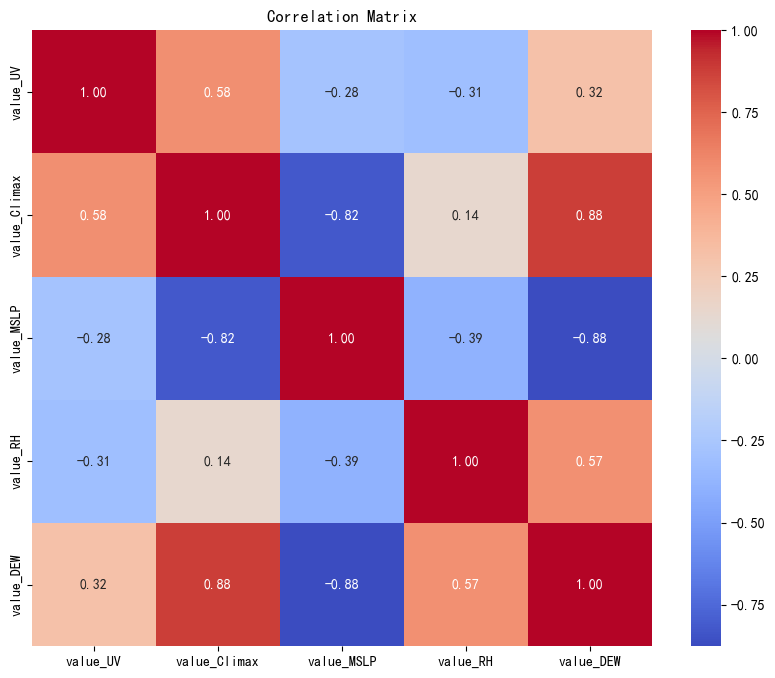

In [44]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 计算相关性矩阵
correlation_matrix = all_data.corr()

# 可视化相关性矩阵
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


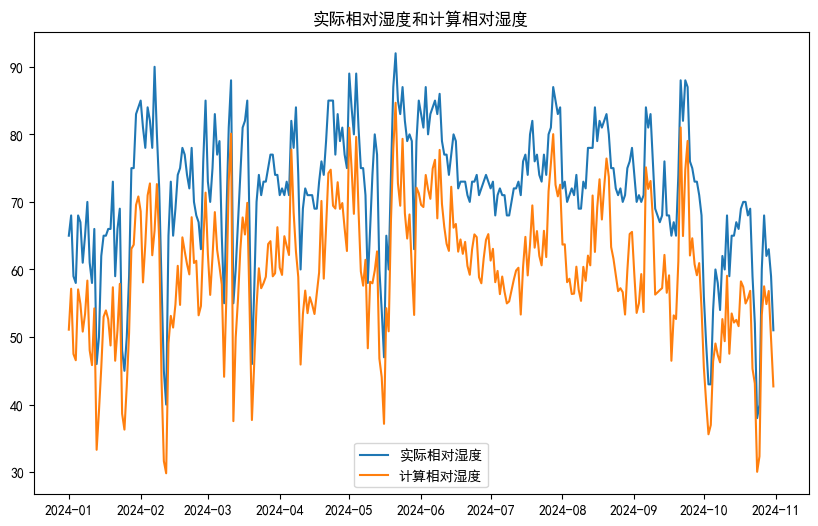

In [48]:
# 使用温度和露点温度计算相对湿度 再和实际相对湿度比较
# 公式：RH = 100*(EXP((17.625*DEW)/(243.04+DEW))/EXP((17.625*CLIMAX)/(243.04+CLIMAX)))
# 其中DEW为露点温度，CLIMAX为温度

all_data['value_RH_calculated'] = 100 * (np.exp((17.62 * all_data['value_DEW']) / (243.15 + all_data['value_DEW'])) / np.exp((17.62 * all_data['value_Climax']) / (243.15 + all_data['value_Climax'])))
all_data['value_RH_calculated'] = all_data['value_RH_calculated'].astype(float)

plt.figure(figsize=(10, 6))
plt.plot(all_data['value_RH'], label='实际相对湿度')
plt.plot(all_data['value_RH_calculated'], label='计算相对湿度')
plt.legend()
plt.title('实际相对湿度和计算相对湿度')
plt.show()


In [ ]:
# 